# Title


## Import Libraries and Data
See prepare-data.ipynb for detail on data prep

In [8]:
#import
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import random
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor

In [9]:
# read in clean data
airbnb_data_dummies = pd.read_csv('./data/clean/cleaned-listings-dummies.csv')
airbnb_data_dummies_bio = pd.read_csv('./data/clean/cleaned-listings-dummies-bio.csv')
airbnb_data_basic = pd.read_csv('./data/clean/cleaned-listings-base.csv')

In [11]:
# list(airbnb_data_dummies_bio.columns.values)
# airbnb_data_dummies_bio.bio_score

## Initial Price Regression
In this section, we take a look at which features **correlate with the listing price** of an Airbnb. We performed a basic ordinary least squares regression, predicting price using a few dozen variables included in our dataset that we felt may be predictive of price. Variables exluded were either almost entirely NaN, or only contained a single value for >90% of listings.

In [12]:
# large formula
formula = 'price ~ host_response_rate + accommodates + guests_included + bathrooms + bedrooms + beds + number_of_reviews + review_scores_rating + review_scores_accuracy + review_scores_cleanliness + review_scores_checkin + review_scores_communication + review_scores_location + review_scores_value + description_score + bio_score + host_is_superhost + neighbourhood_Ballard  + neighbourhood_Cascade  + neighbourhood_Delridge + neighbourhood_Downtown + neighbourhood_Interbay + neighbourhood_Magnolia + neighbourhood_Northgate + property_type_Apartment  + property_type_Condominium + property_type_House + property_type_Loft + property_type_Townhouse + neighbourhood_Beacon_Hill + neighbourhood_Capitol_Hill + neighbourhood_Central_Area + neighbourhood_Lake_City + neighbourhood_Other_neighborhoods + neighbourhood_Queen_Anne + neighbourhood_Rainier_Valley + neighbourhood_Seward_Park + neighbourhood_University_District + neighbourhood_West_Seattle + property_type_Bed_Breakfast + room_type_Entire_home_apt + room_type_Private_room + room_type_Shared_room'
# fit ordinary least squares model
mod1 = smf.ols(formula=formula, data=airbnb_data_dummies_bio).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     102.7
Date:                Thu, 06 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:09:05   Log-Likelihood:                -15683.
No. Observations:                2866   AIC:                         3.145e+04
Df Residuals:                    2825   BIC:                         3.169e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           -34.9327     19.612     -1.781      0.075     -73.387       3.522
host_response_rate                   -0.2391      0.110     -2.177      0.030      -0.454      -0.024
accommodates                          6.7821      1.325      5.119      0.000       4.184       9.380
guests_included                       5.9181      1.007      5.877      0.000       3.944       7.893
bathrooms                            27.4912      2.454     11.201      0.000      22.679      32.304
bedrooms                             32.0212      2.358     13.581      0.000      27.398      36.644
beds                                  0.9383      1.970      0.476      0.634      -2.924       4.801
number_of_reviews                    -0.1448      0.029     -5.022      0.000      -0.201      -0.088
review_scores_rating                  0.9423      0.324      2.907      0.004       0.307       1.578
review_scores_accuracy                0.8123      2.351      0.345      0.730      -3.799       5.423
review_scores_cleanliness             3.1072      2.129      1.459      0.145      -1.068       7.282
review_scores_checkin                -0.7178      2.970     -0.242      0.809      -6.541       5.106
review_scores_communication           0.7479      3.149      0.237      0.812      -5.427       6.923
review_scores_location                3.4408      2.236      1.539      0.124      -0.943       7.824
review_scores_value                  -9.0217      2.341     -3.854      0.000     -13.611      -4.432
description_score                     8.4250      6.350      1.327      0.185      -4.026      20.876
bio_score                           -10.2768      6.131     -1.676      0.094     -22.298       1.744
host_is_superhost                     7.3578      2.739      2.686      0.007       1.987      12.728
neighbourhood_Ballard                -8.3330      4.808     -1.733      0.083     -17.761       1.095
neighbourhood_Cascade                19.7474      7.736      2.553      0.011       4.579      34.916
neighbourhood_Delridge              -22.2770      7.358     -3.028      0.002     -36.704      -7.850
neighbourhood_Downtown               30.6374      3.973      7.712      0.000      22.848      38.427
neighbourhood_Interbay                6.4608     19.513      0.331      0.741     -31.800      44.722
neighbourhood_Magnolia               17.6389      8.913      1.979      0.048       0.163      35.115
neighbourhood_Northgate             -25.2530      7.653     -3.300      0.001     -40.260     -10.246
property_type_Apartment             -13.6635      4.417     -3.093      0.002     -22.325      -5.002
property_type_Condominium           -14.2624      7.469     -1.910      0.056     -28.907       0.382
property_type_House    

Text(0.5, 1.0, 'Sentiment Score vs. Price')

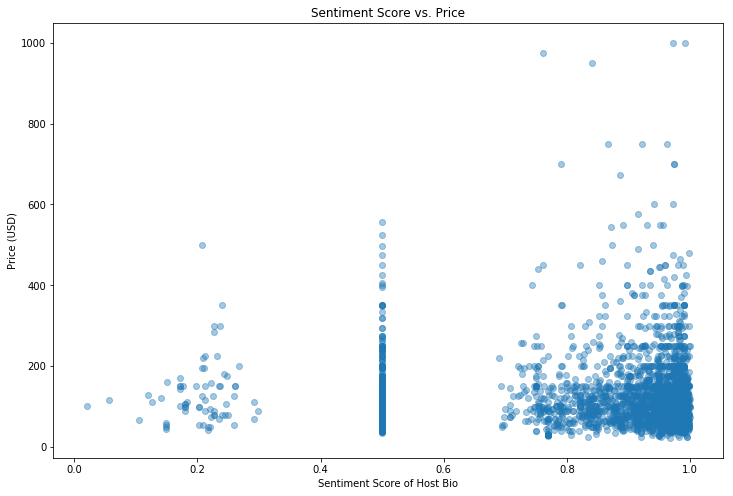

In [15]:
plt.figure(figsize=(12,8))
plt.scatter(airbnb_data_dummies_bio['bio_score'], airbnb_data_dummies_bio['price'], alpha = .4)
plt.xlabel('Sentiment Score of Host Bio')
plt.ylabel('Price (USD)')
plt.title('Sentiment Score vs. Price')

# ML code below

## Predicting Price
After exploring our variables, we began our efforts to predict price. We followed the traditional process covered in lecture of splitting our data, building pipelines, and predicting using different ML models.

In [49]:
# split into train and test
train_features, test_features, train_outcome, test_outcome = train_test_split(
    airbnb_data_dummies.drop("price", axis=1),
    airbnb_data_dummies.price,
    test_size=0.20
)

### KNN Regressor
Our first model was K-Nearest Neighbors, varying the polynomial degree of the regression ,the number of neighbors, and the weight function.

In [28]:
# KNN pipeline
knn_pipeline = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(),
    KNeighborsRegressor()
)

In [29]:
# Grid
knn_param_grid = {
              'polynomialfeatures__degree':range(1,3),
              'kneighborsregressor__n_neighbors':range(1,50,5),
              'kneighborsregressor__weights':['uniform', 'distance']
}

In [30]:
knn_grid = GridSearchCV(knn_pipeline, knn_param_grid, cv=3, scoring="neg_mean_absolute_error")
knn_grid.fit(train_features, train_outcome)
knn_grid.score(test_features, test_outcome)

-38.16366431309363

In [32]:
knn_grid.best_params_

{'kneighborsregressor__n_neighbors': 11,
 'kneighborsregressor__weights': 'distance',
 'polynomialfeatures__degree': 1}

#### KNN Regressor Best Parameters

For our K nearest neighbors regressor we observed the following optimal parameters according to our grid search: 

- Using the closest `11` neighbors
- Using the `distance` weight function when evaluating neighbor influence (defaulted to euclidean) 
- A polynomial degree of `1` was chosen as the best degree out of a range of `(1-3)`


### Random Forests Regressor
Our second model was a Random Forests Regressor, varying the polynomial degree of the regression, the number of trees in the forest, and the maximum depth of each tree.

In [41]:
# RF
rf_pipeline = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(1),
    RandomForestRegressor()
)

In [42]:
# RF Grid
rf_param_grid = {
              'polynomialfeatures__degree':range(1,3),
              'randomforestregressor__n_estimators':range(1,100, 5),
              'randomforestregressor__max_depth':range(1,5)
}

In [43]:
rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, scoring="neg_mean_absolute_error")
rf_grid.fit(train_features, train_outcome)
rf_grid.score(test_features, test_outcome)

-38.00919514435444

In [39]:
rf_grid.best_params_

{'polynomialfeatures__degree': 1,
 'randomforestregressor__max_depth': 4,
 'randomforestregressor__n_estimators': 66}

#### Random Forest Regressor best parameters

For our random forest regressor we observed the following optimal parameters according to our grid search: 

- Using `66` trees in the forest yielded the best results in this combination of parameters
- Using a maximum depth of 4 out of a `(1-5)` range
- A polynomial degree of `1` was chosen as the best degree out of a range of `(1-3)`


### Neural Network Regressor
As a third model, we used a neural network. We varied the learning rate function and the solver technique within our pipeline. 

In [50]:
# Neural Network Pipeline
nn_pipeline = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(1),
    MLPRegressor()
)

In [51]:
nn_param_grid = {
              'mlpregressor__learning_rate':["constant", "invscaling", "adaptive"],
              'mlpregressor__solver':["lbfgs", "sgd", "adam"],
              'mlpregressor__activation':["relu"]
}

In [52]:
nn_grid = GridSearchCV(nn_pipeline, nn_param_grid, cv=3, scoring="neg_mean_absolute_error")
nn_grid.fit(train_features, train_outcome)
nn_grid.score(test_features, test_outcome)

-32.99291490578755

In [35]:
nn_grid.best_params_

{'mlpregressor__activation': 'relu',
 'mlpregressor__learning_rate': 'adaptive',
 'mlpregressor__solver': 'sgd'}

### Neural Network Regressor Best Parameters

For our neural network multi-layer perceptron regressor we observed the following optimal parameters according to our grid search: 

- Using the `relu` activation function for the hidden layer 
- Using a constant learning rate (over `invscaling`)
- Using a stochastic gradient descent solver for weight optimization
- A polynomial degree of `1` was chosen as the best degree out of a range of `(1-3)`


## Choosing Our Best Model 

After rigorously testing all of models defined above, the model that consistently performed the best was the **multi-layer perceptron** neural net. Out of the three, k nearest neighbor typically reported mean absolute errors in the `(38-35)` range, random forest reported mean absolute errors in the `(37-34)` range, and the neural network scored in the `(35-32)` range. Comparing the spread of each model’s errors against the test data confirms the neural network as the _most accurate_ of the three.

## Visualizing Pricing Predictions

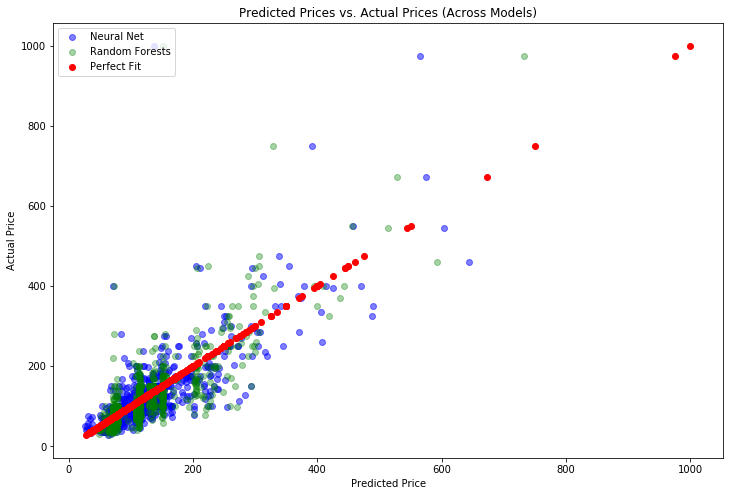

In [53]:
plt.figure(figsize=(12,8))
plt.scatter(nn_grid.predict(test_features),test_outcome,color='b', alpha = .5, label = 'Neural Net')
plt.scatter(rf_grid.predict(test_features),test_outcome,color='g', alpha = .35, label = 'Random Forests')
plt.scatter(test_outcome, test_outcome, color = 'r', label = 'Perfect Fit')
# plt.scatter(knn_grid.predict(test_features),test_outcome,color='r', alpha = .25, label = 'K-Nearest Neighbors')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.legend(loc='upper left')
plt.title("Predicted Prices vs. Actual Prices (Across Models)")

plt.show()

The figure above is a visualization of our predicted prices through both the Random Forests and Neural Net methods, our two best performing models.

We were fairly satisfied with the shape of this plot, with the data generally resembling a pattern of slope 1, which indicates relatively accurate predictions.

Predictions from both models look quite similar, although the numbers indicate that the Neural Net method produced slightly better results. Noticeable differences include the highly concentrated clumping from the Random Forest at different intervals, likely due to the model predicting prices at common price points like 85, 100, and 150. 

## Visualizing Predictive Error

Next, we plotted the error across the different models to see how the difference between prediction and actual prices of listings varied across different parameters. Our first scatterplot illustrates how our error changes across listings of different prices.

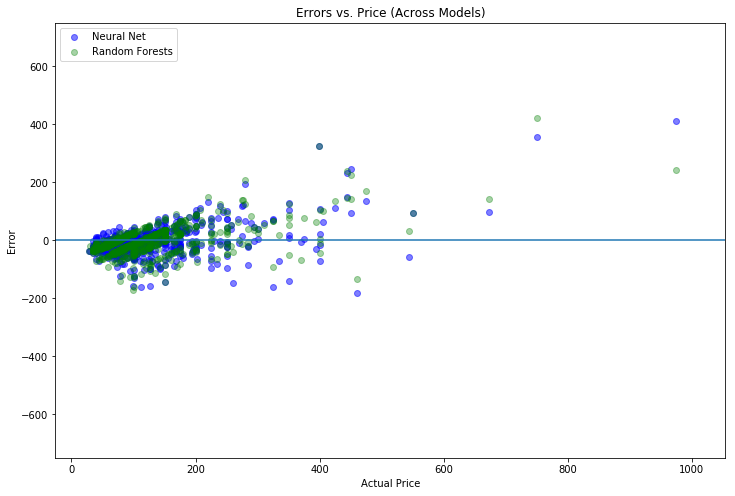

In [54]:
plt.figure(figsize=(12,8))
plt.scatter(test_outcome,test_outcome - nn_grid.predict(test_features),color='b', alpha = .5, label = 'Neural Net')
plt.scatter(test_outcome,test_outcome - rf_grid.predict(test_features),color='g', alpha = .35, label = 'Random Forests')
#plt.scatter(test_outcome,test_outcome - knn_grid.predict(test_features),color='g', alpha = .5, label = 'Random Forests')
plt.axhline(y = 0)
plt.ylim(-750, 750)
plt.xlabel('Actual Price')
plt.ylabel('Error')
plt.title("Errors vs. Price (Across Models)")
plt.legend(loc='upper left')
plt.show()

Again, we were pleasently surprised with how clumped our error was around 0. However, our models becomes less and less accurate as the price of the listing increases. We imagine that this is likely because features that set high-end Airbnb's apart in price (such as privacy of location, quality of home, specific ammenities) were not captured within our dataset. 

In terms of comparing our models, the difference in errors is slight, but the neural net does seem to be clumped a bit more consistently toward zero. 

Interesting observations are that our models seemed to mispredict similar listings. You often see pairs of blue and green dots together, indicating that listings that that one model mispredicts, the other model is likely to mispredict as well. There also appear to be claw-like "streaks" produced by the Random Forest regressor, mirroring the linear patterns in the previous visualization.

###  Error and Property Type 
We then made a violin plot to compare the errors for the Neural Net (our best model) across all property types, to see if we were better or worse at predicting specific properties. 

In [39]:
# prepare data for plotting
listings_clean = pd.read_csv('data/cleaned-listings-base.csv')
property_errors = pd.DataFrame(listings_clean['property_type'])

# get errors for the neural network
nn_errors =  pd.DataFrame(test_outcome - nn_grid.predict(test_features))
nn_errors.rename({"price": "error"}, axis='columns', inplace=True)

# overwrite indexes because this is horrible
nn_errors.index = nn_errors.index.astype(str)
property_errors.index = property_errors.index.astype(str)

res = nn_errors.join(property_errors)

res.error = res.error.abs()

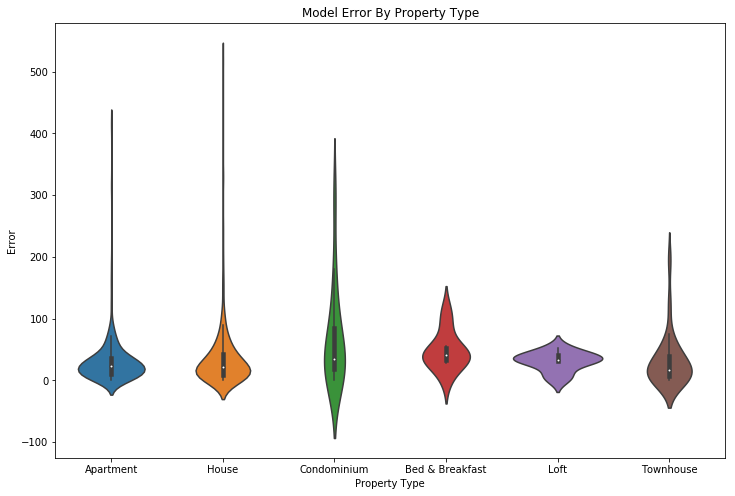

In [40]:
# use this to reset
# sns.reset_orig()


plt.figure(figsize=(12,8))
violin_plot = sns.violinplot(x="property_type", y="error", data=res)

plt.xlabel('Property Type')
plt.ylabel('Error') 
plt.title('Model Error By Property Type')

plt.show(violin_plot)